# Flight Data Exploration

* Created live on stream.
Watch the video here: https://youtu.be/xs_L6z9QNYY

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

pd.set_option("display.max_columns", 500)
plt.style.use("seaborn-colorblind")
pal = sns.color_palette()

In [2]:
!ls -GFlash ../input/flight-delay-dataset-20182022/ | grep parquet

216M -rw-r--r-- 1 nobody 216M Mar 11 22:55 Combined_Flights_2018.parquet
295M -rw-r--r-- 1 nobody 295M Mar 11 22:55 Combined_Flights_2019.parquet
175M -rw-r--r-- 1 nobody 175M Mar 11 22:55 Combined_Flights_2020.parquet
232M -rw-r--r-- 1 nobody 232M Mar 11 22:55 Combined_Flights_2021.parquet
143M -rw-r--r-- 1 nobody 143M Mar 11 22:55 Combined_Flights_2022.parquet


In [3]:
!ls -GFlash ../input/flight-delay-dataset-20182022/ | grep csv

 40K -rw-r--r-- 1 nobody  39K Mar 11 22:54 Airlines.csv
1.9G -rw-r--r-- 1 nobody 1.9G Mar 11 22:56 Combined_Flights_2018.csv
2.7G -rw-r--r-- 1 nobody 2.7G Mar 11 22:56 Combined_Flights_2019.csv
1.7G -rw-r--r-- 1 nobody 1.7G Mar 11 22:56 Combined_Flights_2020.csv
2.1G -rw-r--r-- 1 nobody 2.1G Mar 11 22:56 Combined_Flights_2021.csv
1.4G -rw-r--r-- 1 nobody 1.4G Mar 11 22:56 Combined_Flights_2022.csv


# Read in and Format Data

In [4]:
parquet_files = glob("../input/flight-delay-dataset-20182022/*.parquet")

In [5]:
column_subset = [
    "FlightDate",
    "Airline",
    "Flight_Number_Marketing_Airline",
    "Origin",
    "Dest",
    "Cancelled",
    "Diverted",
    "CRSDepTime",
    "DepTime",
    "DepDelayMinutes",
    "OriginAirportID",
    "OriginCityName",
    "OriginStateName",
    "DestAirportID",
    "DestCityName",
    "DestStateName",
    "TaxiOut",
    "TaxiIn",
    "CRSArrTime",
    "ArrTime",
    "ArrDelayMinutes",
]

dfs = []
for f in parquet_files:
    dfs.append(pd.read_parquet(f, columns=column_subset))
df = pd.concat(dfs).reset_index(drop=True)

cat_cols = ["Airline", "Origin", "Dest", "OriginStateName", "DestStateName"]
for c in cat_cols:
    df[c] = df[c].astype("category")

# Understand the `DepDelayMinutes` Variable

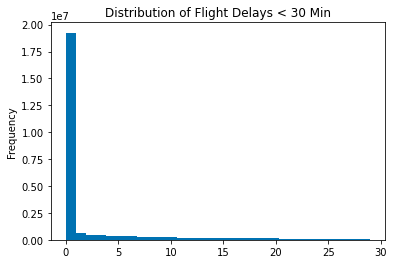

In [6]:
df.query("DepDelayMinutes < 30")["DepDelayMinutes"].plot(
    kind="hist", bins=30, title="Distribution of Flight Delays < 30 Min"
)
plt.show()

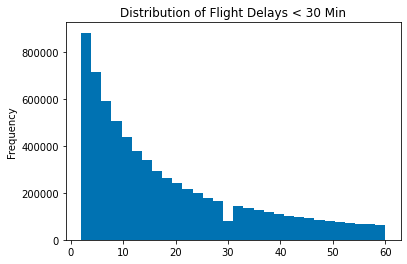

In [7]:
df.query("DepDelayMinutes > 1 and DepDelayMinutes < 61")["DepDelayMinutes"].plot(
    kind="hist", bins=30, title="Distribution of Flight Delays < 30 Min"
)
plt.show()

# Grouping of Delays
Per Wikipedia https://en.wikipedia.org/wiki/Flight_cancellation_and_delay:
```
Delays are divided into three categories, namely "on time or small delay" (up to 15 minutes delay), "Medium delay" (15 – 45 minutes delay) and "Large delay" ( 45 minutes delay). 
```

In [8]:
df["DelayGroup"] = None
df.loc[df["DepDelayMinutes"] == 0, "DelayGroup"] = "OnTime_Early"
df.loc[
    (df["DepDelayMinutes"] > 0) & (df["DepDelayMinutes"] <= 15), "DelayGroup"
] = "Small_Delay"
df.loc[
    (df["DepDelayMinutes"] > 15) & (df["DepDelayMinutes"] <= 45), "DelayGroup"
] = "Medium_Delay"
df.loc[df["DepDelayMinutes"] > 45, "DelayGroup"] = "Large_Delay"
df.loc[df["Cancelled"], "DelayGroup"] = "Cancelled"

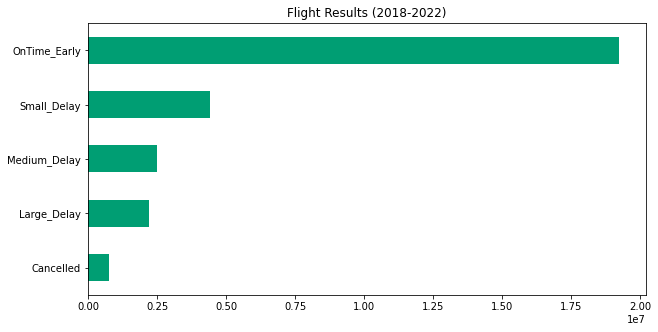

In [9]:
df["DelayGroup"].value_counts(ascending=True).plot(
    kind="barh", figsize=(10, 5), color=pal[1], title="Flight Results (2018-2022)"
)
plt.show()

# How Many Flights Per Year?

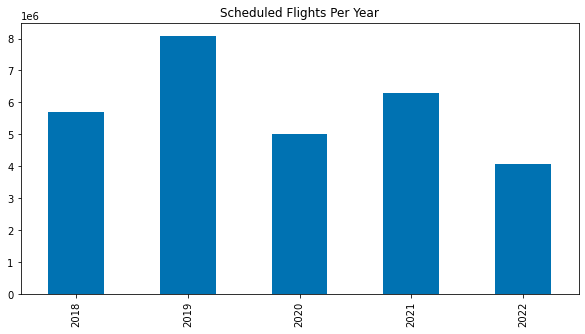

In [10]:
df["Year"] = df['FlightDate'].dt.year
df["Year"].value_counts().sort_index().plot(
    kind="bar", figsize=(10, 5), title="Scheduled Flights Per Year"
)
plt.show()

# What is the % of Flight Results by Year

In [11]:
df["Year"] = df["FlightDate"].dt.year
df_agg = df.groupby("Year")["DelayGroup"].value_counts(normalize=True).unstack() * 100
col_order = ["OnTime_Early", "Small_Delay", "Medium_Delay", "Large_Delay", "Cancelled"]
df_agg[col_order].style.background_gradient(cmap="Greens")

DelayGroup,OnTime_Early,Small_Delay,Medium_Delay,Large_Delay,Cancelled
Year,,,,,
2018,64.115615,16.474583,9.538448,8.317789,1.553565
2019,64.619787,15.716778,9.081583,8.683248,1.898604
2020,76.052291,9.653418,4.572319,3.727722,5.994249
2021,65.698142,16.145308,8.917879,7.479795,1.758876
2022,58.801153,17.706368,10.926539,9.545283,3.020657


# Results by Month

In [12]:
df["Month"] = df["FlightDate"].dt.month
df_agg = df.groupby("Month")["DelayGroup"].value_counts(normalize=True).unstack() * 100
col_order = ["OnTime_Early", "Small_Delay", "Medium_Delay", "Large_Delay", "Cancelled"]
df_agg[col_order].style.background_gradient(cmap="Blues")

DelayGroup,OnTime_Early,Small_Delay,Medium_Delay,Large_Delay,Cancelled
Month,,,,,
1,68.169907,13.961832,7.878093,7.008976,2.981192
2,64.960611,15.300969,8.828322,7.786858,3.123240
3,66.363322,14.172305,7.716007,6.173113,5.575252
4,64.436275,14.051844,7.824258,6.853866,6.833756
5,65.023841,16.224252,8.965554,7.875154,1.911198
6,59.488265,17.349791,10.754222,10.442093,1.965629
7,61.996702,16.361900,10.052315,9.906083,1.683000
8,64.622096,15.009025,9.096512,9.137345,2.135022
9,72.924881,13.140776,6.725733,5.813787,1.394822


## Exclude 2020

In [13]:
df["Month"] = df["FlightDate"].dt.month
df_agg = (
    df.query("Year != 2020")
    .groupby("Month")["DelayGroup"]
    .value_counts(normalize=True)
    .unstack()
    * 100
)
col_order = ["OnTime_Early", "Small_Delay", "Medium_Delay", "Large_Delay", "Cancelled"]
df_agg[col_order].style.background_gradient(cmap="Blues")

DelayGroup,OnTime_Early,Small_Delay,Medium_Delay,Large_Delay,Cancelled
Month,,,,,
1,67.162457,13.880797,8.068641,7.353867,3.534239
2,62.623134,15.912800,9.424684,8.139587,3.899795
3,65.869000,16.332230,8.904784,7.101697,1.792290
4,66.161402,15.715543,8.783821,7.685515,1.653719
5,63.468665,17.070321,9.537899,8.407955,1.515159
6,56.855480,18.188167,11.525967,11.298683,2.131703
7,58.511717,17.645319,11.048691,10.968325,1.825949
8,60.348823,16.490201,10.289753,10.508081,2.363141
9,70.637088,14.016242,7.374660,6.454308,1.517702


## Why High Cancellation in March/April? What does it look like by year for these months?

In [14]:
df["Month"] = df["FlightDate"].dt.month
df_agg = (
    df.query("3 <= Month <= 4")
    .groupby("Year")["DelayGroup"]
    .value_counts(normalize=True)
    .unstack()
    * 100
)
col_order = ["OnTime_Early", "Small_Delay", "Medium_Delay", "Large_Delay", "Cancelled"]
df_agg[col_order].style.background_gradient(cmap="Oranges", axis=0)

DelayGroup,OnTime_Early,Small_Delay,Medium_Delay,Large_Delay,Cancelled
Year,,,,,
2018,64.219260,17.194531,9.582907,7.347652,1.655651
2019,65.790141,15.462990,8.614418,7.974924,2.157527
2020,63.063286,6.202543,3.291875,2.733237,24.709059
2021,76.291254,13.015721,5.715776,4.077733,0.899516
2022,59.301505,18.234213,11.096981,9.445164,1.922137


# Plot using `calmap`

In [15]:
!pip install calmap plotly_calplot -q

Text(0.5, 0.92, 'US Flight Cancellations')

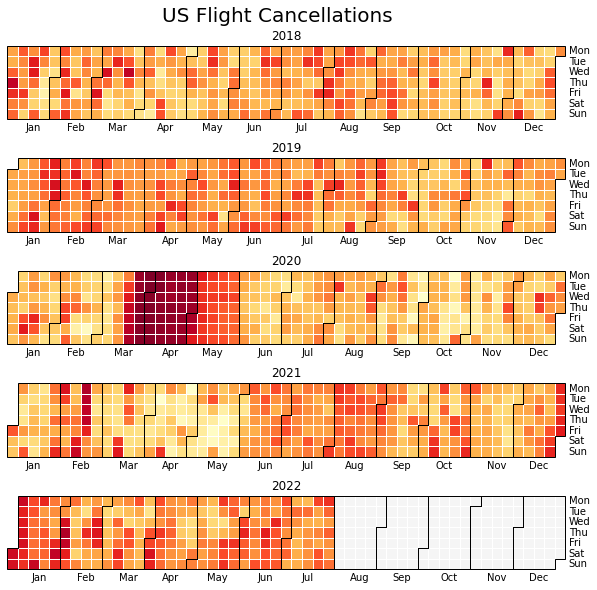

In [16]:
import calmap
events = df.groupby("FlightDate")["Cancelled"].mean()
fig, axs = plt.subplots(5, 1, figsize=(10, 10))
for i, year in enumerate([2018, 2019, 2020, 2021, 2022]):
    calmap.yearplot(
        events.apply(np.log), year=year, cmap="YlOrRd", monthly_border=True, ax=axs[i]
    )
    axs[i].set_title(year)
fig.patch.set_facecolor("white")
fig.suptitle("US Flight Cancellations", y=0.92, fontsize=20)

# Interactive Calendar Heatmap

In [17]:
from plotly_calplot import calplot

# creating the plot
fig = calplot(events.apply(np.log).reset_index(), x="FlightDate", y="Cancelled")
fig.show()

# Compare Airlines
- Who has the most delays?
- Who has the most cancellations?
- Who is the most reliable? (on time)

Text(0.5, 0, 'Flights (100k)')

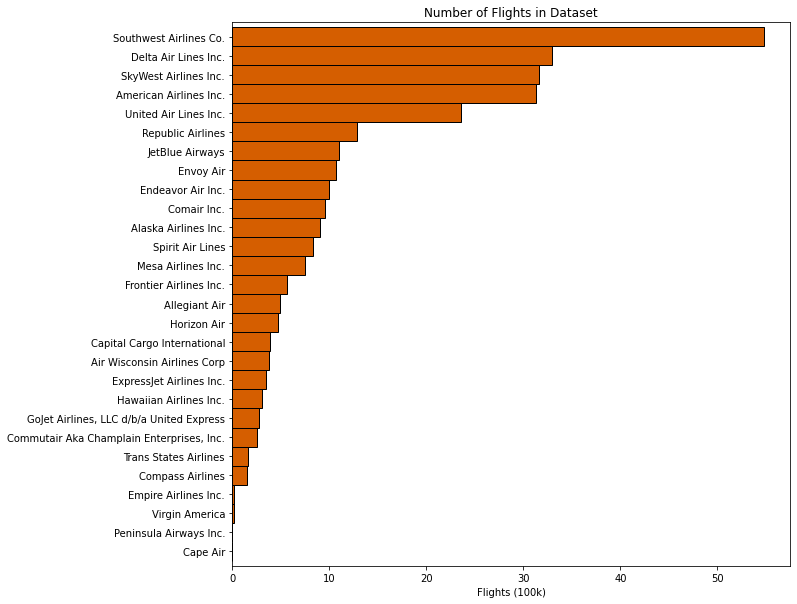

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))
airlines_ordered = (df["Airline"].value_counts(ascending=True) / 100_000).plot(
    kind="barh", ax=ax, color=pal[2], width=1, edgecolor="black"
)
ax.set_title("Number of Flights in Dataset")
ax.set_xlabel("Flights (100k)")

## Subset to the Top Airlines
- Minimum 1M Flights

In [19]:
top_airlines = (
    df["Airline"]
    .value_counts()
    .reset_index()
    .query("Airline > 1_000_000")["index"]
    .values.tolist()
)

df_top = df.loc[df["Airline"].isin(top_airlines)].reset_index(drop=True).copy()

In [20]:
# Reset airline categories
df_top["Airline"] = df_top["Airline"].astype("str").astype("category")

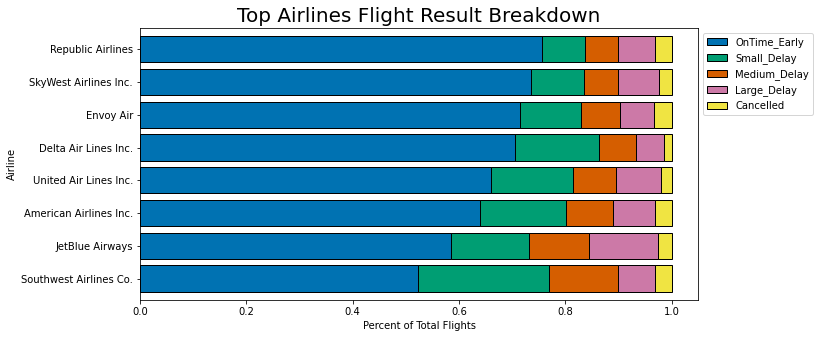

In [21]:
col_order = ["OnTime_Early", "Small_Delay", "Medium_Delay", "Large_Delay", "Cancelled"]

df_agg = (
    df_top.groupby(["Airline"])["DelayGroup"]
    .value_counts(normalize=True)
    .unstack()[col_order]
)

fig, ax = plt.subplots(figsize=(10, 5))
df_agg.sort_values("OnTime_Early").plot(
    kind="barh", stacked=True, ax=ax, width=0.8, edgecolor="black"
)
ax.legend(bbox_to_anchor=(1, 1))
ax.set_title("Top Airlines Flight Result Breakdown", fontsize=20)
ax.set_xlabel("Percent of Total Flights")
plt.show()

## Split out Each Delay Type and plot

In [22]:
delay_mapping = {
    "OnTime_Early": "Good",
    "Small_Delay": "Good",
    "Medium_Delay": "Bad",
    "Large_Delay": "Bad",
    "Cancelled": "Bad",
}

In [23]:
df_top["DelayOk"] = df_top["DelayGroup"].map(delay_mapping)

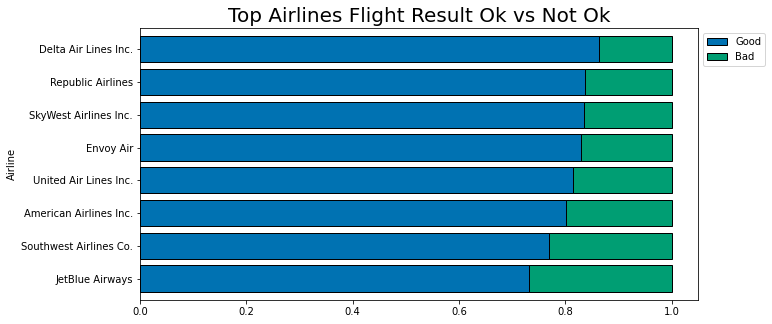

In [24]:
df_agg = (
    df_top.groupby(["Airline"])["DelayOk"]
    .value_counts(normalize=True)
    .unstack()[["Good", "Bad"]]
)

fig, ax = plt.subplots(figsize=(10, 5))
df_agg.sort_values("Good").plot(
    kind="barh", stacked=True, ax=ax, width=0.8, edgecolor="black"
)
ax.legend(bbox_to_anchor=(1, 1))
ax.set_title("Top Airlines Flight Result Ok vs Not Ok", fontsize=20)

plt.show()